# Préparation des données

## Import et data augmentations

In [61]:
from  src.dataloader import *
from src.metrics import *
from src.resnet18 import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
import tensorflow as tf
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score, recall_score, fbeta_score, precision_recall_curve, auc, roc_curve
import torchvision.models as models
import os

721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(1)


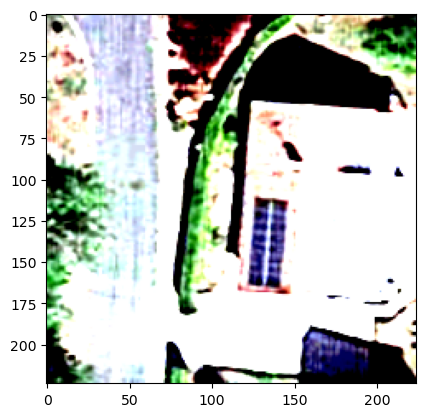

In [62]:
np.random.seed(123)
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.RandomCrop(190), #On garde environ 75% de l'image
                                               transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),                                               transforms.RandomCrop(160),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3492203652858734, 0.3565990626811981, 0.3071053624153137],
                                                                    std= [0.2003859430551529, 0.18338431417942047, 0.17826561629772186]),

                                           ]))

transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3498302698135376, 0.3575190603733063, 0.30798372626304626],
                                                                    std= [0.20142625272274017, 0.1843339055776596, 0.17957480251789093]),
                                           ]))

train_dataloader_augmente = DataLoader(transformed_train_dataset, batch_size=32, shuffle=True)
test_dataloader_augmente = DataLoader(transformed_test_dataset, batch_size=32, shuffle=True)

print(len(train_dataloader_augmente))
batch = next(iter(train_dataloader_augmente))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [64]:
resnet18 = models.resnet18(pretrained=True)

#Furthermore, in feature extracting, we don't need to calculate gradient for any layers except 
# the last layer that we initialize. For this we need to set .requires_grad to False
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)


nr_filters = resnet18.fc.in_features  #number of input features of last layer
#On ne met pas de sigmoid dans la dernière couche. C'est composé par la loss BCEWithLogitsLoss qui applique une sigmoid afin de calculer la cross-enthropy
resnet18.fc = nn.Linear(nr_filters, 1)

resnet18.layer1.append(nn.Dropout(0.1))
resnet18.layer2.append(nn.Dropout(0.6))
resnet18.layer3.append(nn.Dropout(0.3))
resnet18.layer4.append(nn.Dropout(0.8))


Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [102]:
def sig(x):
    return 1/(1 + np.exp(-x))

def train_model(model, train_loader,criterion, n_epochs, batch_size, path_save_model, device=None):
    """Pour entrainer le modèle 
    /!\ certains commentaires sont à passer en code pour passer sur GPU
    """
    # number of epochs to train the model

    train_losses= []
    train_f1s=[]
    train_accuracys=[]
    train_recalls=[]
    train_f2s=[]

    # Here we only want to update the gradient for the classifier layer that we initialized.
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

    optimizer=torch.optim.SGD(params_to_update, lr = 0.01, momentum=0.9, weight_decay=1e-4)
    
    for epoch in range(n_epochs):

        # monitor losses
        train_loss = 0

        train_f1=0

        train_accuracy=0

        train_recall=0

        train_f2=0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for data,label in train_loader:
            
            # Pour utiliser GPU

            # inputs = inputs.to(device)
            # labels = labels.to(device)
            # model.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            output_detach = output.detach()

            # calculate the loss
            preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
            for i in range(len(output_detach)):
                if sig(output_detach[i])>0.5:
                    preds[i]=1
                else: preds[i]=0

            loss = criterion(output,label.unsqueeze(1).float())
            f1 = f1_score(label.numpy(), preds.T.numpy()[0])
            accuracy= accuracy_score(label.numpy(), preds.T.numpy()[0])
            recall= recall_score(label.numpy(), preds.T.numpy()[0])
            f2=fbeta_score(label.numpy(), preds.T.numpy()[0], beta=2)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss

            #loss.item(): retourne la valeur numérique de la loss transférée au CPU
            #loss.item() retourne la loss moyenne sur le mini-batch, d'où la multiplication
            #par data.size(0)
            train_loss += loss.item() * data.size(0)
            train_f1+=f1
            train_accuracy+=accuracy
            train_recall+=recall
            train_f2+=f2    

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler) 

        train_f1=train_f1/(len(train_loader.sampler)/batch_size)

        train_accuracy=train_accuracy/(len(train_loader.sampler)/batch_size)

        train_recall=train_recall/(len(train_loader.sampler)/batch_size)

        train_f2=train_f2/(len(train_loader.sampler)/batch_size)

        train_losses.append(train_loss)

        train_f1s.append(train_f1)

        train_accuracys.append(train_accuracy)

        train_recalls.append(train_recall)

        train_f2s.append(train_f2)


        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining F1-score: {:.6f} \tTraining accuracy: {:.6f} \tTraining recall: {:.6f} \tTraining F2-score: {:.6f}'.format(
            epoch+1, 
            train_loss,
            train_f1,
            train_accuracy,
            train_recall,
            train_f2,
            ))
        
    torch.save(model.state_dict(), os.path.join(path_save_model,"trained_resnet18.pth"))

    return train_losses, train_f1s, train_accuracys, train_recalls, train_f2s 


def eval_model(model, path_model, valid_loader, criterion, n_epochs, batch_size, device=None):
    """Pour voir les performances du modèle entraîné sur l'échantillon de validation
       /!\ certains commentaires sont à passer en code pour passer sur GPU

    """
    ######################    
    # validate the model #
    ######################
    valid_loss_min = np.Inf  # set initial "min" to infinity
    val_losses= []
    val_f1s=[]
    val_accuracys=[]
    val_recalls=[]
    val_f2s=[]

    model.load_state_dict(torch.load(path_model))
    model.eval()  # prep model for evaluation

    #model.to(device)

    for epoch in range(n_epochs):
        valid_loss=0
        valid_f1=0
        valid_accuracy=0
        valid_recall=0
        valid_f2=0

        for data,label in valid_loader:
            # Pour utiliser GPU

            # inputs = inputs.to(device)
            # labels = labels.to(device)
            # model.to(device)

            with torch.no_grad():
                output = model(data)
                
            output_detach = output.detach()

            # calculate the loss
            preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
            for i in range(len(output_detach)):
                if sig(output_detach[i])>0.5:
                    preds[i]=1
                else: preds[i]=0
            
            loss = criterion(output,label.unsqueeze(1).float())
            f1 = f1_score(label.numpy(), preds.T.numpy()[0])
            accuracy= accuracy_score(label.numpy(), preds.T.numpy()[0])
            recall= recall_score(label.numpy(), preds.T.numpy()[0])
            f2=fbeta_score(label.numpy(), preds.T.numpy()[0], beta=2)

            # update running validation loss 
            valid_loss+= loss.item() * data.size(0)
            valid_f1+=f1
            valid_accuracy+=accuracy
            valid_recall+=recall
            valid_f2+=f2

        valid_loss=valid_loss/len(valid_loader.sampler)
        valid_f1=valid_f1/(len(valid_loader.sampler)/batch_size)
        valid_accuracy=valid_accuracy/(len(valid_loader.sampler)/batch_size)
        valid_recall=valid_recall/(len(valid_loader.sampler)/batch_size)
        valid_f2=valid_f2/(len(valid_loader.sampler)/batch_size)

        val_losses.append(valid_loss)
        val_f1s.append(valid_f1)
        val_accuracys.append(valid_accuracy)
        val_recalls.append(valid_recall)
        val_f2s.append(valid_f2)

        print('Epoch: {} \tValidation Loss: {:.6f} \tValidation F1-score: {:.6f} \tValidation accuracy: {:.6f} \tValidation recall: {:.6f} \tValidation F2-score: {:.6f}'.format(
            epoch+1,
            valid_loss,
            valid_f1,
            valid_accuracy,
            valid_recall,
            valid_f2
            ))
        
    return val_losses, val_f1s, val_accuracys, val_recalls, val_f2s


def predict(model, path_model, valid_loader, device=None):
    """Pour prédire 0/1 à partir de l'échantillon de validation
       /!\ certains commentaires sont à passer en code pour passer sur GPU

    """
    model.load_state_dict(torch.load(path_model))
    model.eval()

    array_labels=np.array([])
    array_preds=np.array([])

    for data,label in valid_loader:
        # Pour utiliser GPU

        # inputs = inputs.to(device)
        # labels = labels.to(device)
        # model.to(device)

        with torch.no_grad():
            output = model(data)
        output_detach = output.detach()

        # calculate the loss
        preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
        for i in range(len(output_detach)):
            if sig(output_detach[i])>0.5:
                preds[i]=1
            else: preds[i]=0
        array_preds=np.append(array_preds,preds.T.numpy()[0])
        array_labels=np.append(array_labels, label.numpy())

    return array_labels, array_preds  

In [103]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss=nn.BCEWithLogitsLoss()
# Train model
train_losses, train_f1s, train_accuracys, train_recalls, train_f2s = train_model(model=resnet18, 
                                                                                 train_loader=train_dataloader_augmente, 
                                                                                 criterion=loss, 
                                                                                 n_epochs=40, 
                                                                                 batch_size=32,
                                                                                 path_save_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                                                                 device=None)

print(train_losses)
print(train_f1s)
print(train_accuracys)
print(train_recalls)
print(train_f2s)

	 fc.weight
	 fc.bias
Epoch: 1 	Training Loss: 0.631071 	Training F1-score: 0.022836 	Training accuracy: 0.022795 	Training recall: 0.023702 	Training F2-score: 0.023193
Epoch: 2 	Training Loss: 0.658527 	Training F1-score: 0.022681 	Training accuracy: 0.022640 	Training recall: 0.023575 	Training F2-score: 0.023033


In [134]:
val_losses, val_f1s, val_accuracys, val_recalls, val_f2s = eval_model(model=resnet18
                                                                      , path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18.pth"
                                                                      , valid_loader=test_dataloader_augmente
                                                                      , criterion=loss 
                                                                      , n_epochs=40
                                                                      , batch_size=32
                                                                      , device=None)

3170.849800772965
0.03612909093499184
2
Epoch: 1 	Validation Loss: 0.550304 	Validation F1-score: 0.734653 	Validation accuracy: 0.747657 	Validation recall: 0.672819 	Validation F2-score: 0.694973
3170.8498031497
0.2363949716091156
2
Epoch: 2 	Validation Loss: 0.550304 	Validation F1-score: 0.735512 	Validation accuracy: 0.747657 	Validation recall: 0.672340 	Validation F2-score: 0.695214


In [148]:
y_true, y_pred=predict(model=resnet18, path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18.pth", valid_loader=test_dataloader_augmente, device=None)

print(len(y_true))
print(len(y_pred))

print(y_true)
print(y_pred)

# Lancement du modèle

Les cinq premières métriques représentent les performances de notre algorithme sur l'échantillon d'entrainement, les cinq dernières valeurs (celles précédées du préfixe val_) sont elles calculées sur l'échantillon de test. 

In [ ]:
# model_init = buildModel()
# history=model_init.fit(x = X_train_permute.numpy(), y = Y_train.numpy(),
# 	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
# 	batch_size=32,
# 	epochs=20)

In [ ]:
# recall = history.history['recall_m']
# val_recall = history.history['val_recall_m']

# accuracy = history.history['Accuracy']
# val_accuracy = history.history['val_Accuracy']

# precision = history.history['precision_m']
# val_precision = history.history['val_precision_m']

# f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']

# f2 = history.history['f2_m']
# val_f2 = history.history['val_f2_m']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(recall) + 1)

# fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# axs[0, 0].plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
# axs[0, 0].plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
# axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
# axs[0, 0].legend()

# axs[0, 1].plot(epochs, accuracy, 'b', label="Accuracy sur l'échantillon d'apprentissage")
# axs[0, 1].plot(epochs, val_accuracy, 'b', label="Accuracy sur l'échantillon test", color="red")
# axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
# axs[0, 1].legend()

# axs[1, 0].plot(epochs, precision, 'b', label="Precision sur l'échantillon d'apprentissage")
# axs[1, 0].plot(epochs, val_precision, 'b', label="Precision sur l'échantillon test", color="red")
# axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
# axs[1, 0].legend()

# axs[1, 1].plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
# axs[1, 1].plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
# axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
# axs[1, 1].legend()

# axs[2, 0].plot(epochs, f1, 'b', label="F1-score sur l'échantillon d'apprentissage")
# axs[2, 0].plot(epochs, val_f1, 'b', label="F1-score sur l'échantillon test", color="red")
# axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
# axs[2, 0].legend()

# axs[2, 1].plot(epochs, f2, 'b', label="F2-score sur l'échantillon d'apprentissage")
# axs[2, 1].plot(epochs, val_f2, 'b', label="F2-score sur l'échantillon test", color="red")
# axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
# axs[2, 1].legend()

# plt.show()

In [ ]:
# train_loss, train_accuracy, train_recall, train_precision, train_f1score, train_f2score = model_init.evaluate(
#     X_train_permute.numpy(), Y_train.numpy(), verbose=0)
# print("Loss sur l'échantillon train: {}".format(round(train_loss, 3)))
# print("Accuracy sur l'échantillon train: {}".format(round(train_accuracy, 3)))
# print("Recall sur l'échantillon train: {}".format(round(train_recall, 3)))
# print("Precision sur l'échantillon train: {}".format(round(train_precision, 3)))
# print("F1-score sur l'échantillon train: {}".format(round(train_f1score, 3)))
# print("F2-score sur l'échantillon train: {}".format(round(train_f2score, 3)))

# loss, accuracy, recall, precision, f1score, f2score = model_init.evaluate(
#     X_test_permute.numpy(), Y_test.numpy(), verbose=0)
# print("Loss sur l'échantillon test: {}".format(round(loss, 3)))
# print("Accuracy sur l'échantillon test: {}".format(round(accuracy, 3)))
# print("Recall sur l'échantillon test: {}".format(round(recall, 3)))
# print("Precision sur l'échantillon test: {}".format(round(precision, 3)))
# print("F1-score sur l'échantillon test: {}".format(round(f1score, 3)))
# print("F2-score sur l'échantillon test: {}".format(round(f2score, 3)))

# prob_predict = model_init.predict(X_test_permute.numpy())
# y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

# unique, counts = np.unique(y_pred, return_counts=True)
# res=dict(zip(unique, counts))
# print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
# print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Loss sur l'échantillon test: 1.064
Accuracy sur l'échantillon test: 0.438
Recall sur l'échantillon test: 0.706
Precision sur l'échantillon test: 0.48
F1-score sur l'échantillon test: 0.571


# Hyperparamétrisation du ResNet-18

In [ ]:
# learnRate = [1e-2, 1e-3, 1e-4]
# momentum = [0.9, 0.99]
# dropout1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout5 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# weight_decay=[1e-4, 1e-6]
# batchSize = [4, 8, 16, 32, 64, 128, 256]
# epochs = [10, 20, 30, 40, 50]

# grid = dict(
#     learnRate=learnRate,
#     momentum=momentum,
#     dropout1=dropout1,
#     dropout2=dropout2,
#     dropout3=dropout3,
#     dropout4=dropout4,
#     dropout5=dropout5,
#     weight_decay=weight_decay,
#     batch_size=batchSize,
#     epochs=epochs
# )

# model = KerasClassifier(build_fn=buildModel, verbose=1)
# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# searcher = RandomizedSearchCV(
#     estimator=model, cv=5, n_iter=10, param_distributions=grid, scoring=ftwo_scorer)
# searchResults = searcher.fit(
#     X_train_augmente_permute.numpy(), Y_train_augmente.numpy())
